# CPSC 330 Lecture 14

### Lecture plan

- Announcements
- Today's dataset (10 min)
- Vectors, distances, neighbours (20 min)
- KNN for product similarity (5 min)
- Break (5 min)
- Cosine similarity (15 min)
- KNN for supervised learning (15 min) -> move to leftovers lecture?
- T/F questions (10 min)

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix
import os 

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import datasets
import sklearn.metrics
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
from IPython.core.display import display, HTML

In [3]:
plt.rcParams['font.size'] = 16

In [4]:
# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

## Announcements

- Final exam date: April 24.
- hw6 coming this weekend, to be due about a week later.

## Today's dataset

We'll be looking at the [Amazon product data set](http://jmcauley.ucsd.edu/data/amazon/). The author of the data set has asked for the following citations:

> Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering.
> R. He, J. McAuley.
> WWW, 2016.
> 
> Image-based recommendations on styles and substitutes.
> J. McAuley, C. Targett, J. Shi, A. van den Hengel.
> SIGIR, 2015.

We will focus on the Patio, Lawn, and Garden section. Please download the [ratings](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Patio_Lawn_and_Garden.csv) and place them in the data directory with their default filenames. The code below should load the data:

In [5]:
ratings = pd.read_csv("data/ratings_Patio_Lawn_and_Garden.csv", names=("user","item","rating","timestamp"))
ratings.head()

,user,item,rating,timestamp
0,A2VNYWOPJ13AFP,0981850006,5.0,1259798400
1,A20DWVV8HML3AW,0981850006,5.0,1371081600
2,A3RVP3YBYYOPRH,0981850006,5.0,1257984000
3,A28XY55TP3Q90O,0981850006,5.0,1314144000
4,A3VZW1BGUQO0V3,0981850006,5.0,1308268800


We'd also like to construct the data matrix `X`. Let's see how big it would be:

In [6]:
def get_stats(ratings, item_key="item", user_key="user"):
    print("Number of ratings:", len(ratings))
    print("The average rating:", np.mean(ratings["rating"]))

    n_items = len(set(ratings[item_key]))
    n_users = len(set(ratings[user_key]))
    print("Number of users:", n_users)
    print("Number of items:", n_items)
    print("Fraction nonzero:", len(ratings)/(n_items*n_users))
    print("Size of full matrix (GB):", (n_items*n_users)*8/1e9)

    return n_items, n_users

n_items, n_users = get_stats(ratings)

Number of ratings: 993490
The average rating: 4.006400668350965
Number of users: 714791
Number of items: 105984
Fraction nonzero: 1.3114269915944552e-05
Size of full matrix (GB): 606.051274752


- We'd like to reshape things into an array of number of users by number of items.
- But, as shown above, this would be about 600 GB! That is way too big.
- This is a prime example of where sparse matrices would be helpful. 
- We only have about 1 million ratings, which would be 8 MB or so. Much more manageable. 

In [8]:
def create_X(ratings, n_items, n_users, user_key="user", item_key="item"):
    """
    Creates a sparse matrix using scipy.csr_matrix and mappers to relate indexes to items' id.
    
    Parameters:
    -----------
    ratings: the ratings to be stored in the matrix;
    n_items: the number of items
    n_users: the number of users
    user_key: the column in the pandas dataframe that contains the users id
    item_key: the column in the pandas dataframe that contains the items id
    
    Returns: (X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind)
    --------
    X: the sparse matrix containing the ratings
    user_mapper: stores the indexes of the users - the user_id is the key
    item_mapper: stores the indexes of the items - the item_id is the key
    user_inverse_mapper: stores the user id - the user index is the key
    item_inverse_mapper: stores the item id - the item index is the key
    user_ind: indexes of the users
    item_ind: indexes of the items
    """
    
    user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(n_users))))
    item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(n_items))))

    user_inverse_mapper = dict(zip(list(range(n_users)), np.unique(ratings[user_key])))
    item_inverse_mapper = dict(zip(list(range(n_items)), np.unique(ratings[item_key])))

    user_ind = [user_mapper[i] for i in ratings[user_key]]
    item_ind = [item_mapper[i] for i in ratings[item_key]]

    X = csc_matrix((ratings["rating"], (item_ind, user_ind)), shape=(n_items, n_users)).T
    
    return X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind

In [9]:
X_user_item, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind = create_X(ratings, n_items, n_users)

In [10]:
type(X_user_item)

scipy.sparse.csr.csr_matrix

In [11]:
X_user_item.shape

(714791, 105984)

In [12]:
X_user_item.nnz

993490

#### EDA

Let's find the following items the item with the most reviews:

In [13]:
idx_most_reviews = np.argmax(np.sum(X_user_item>0, axis=0))
idx_most_reviews

10959

In [14]:
np.max(np.sum(X_user_item>0, axis=0))

3180

Then we can look up the Amazon id:

In [15]:
item_inverse_mapper[idx_most_reviews]

'B000HCLLMM'

And get the URL:

In [16]:
url_amazon = "https://www.amazon.com/dp/%s"
def disp_url(item_id):
    url = url_amazon % item_id
    display(HTML('<a href="%s">%s</a>' % (url,url)))

disp_url(item_inverse_mapper[idx_most_reviews])

We can do the same for the lowest average stars:

In [17]:
idx_lowest_avg = np.argmin(np.sum(X_user_item, axis=0)/np.sum(X_user_item>0,axis=0))

disp_url(item_inverse_mapper[idx_lowest_avg])

Next, we make some histograms:

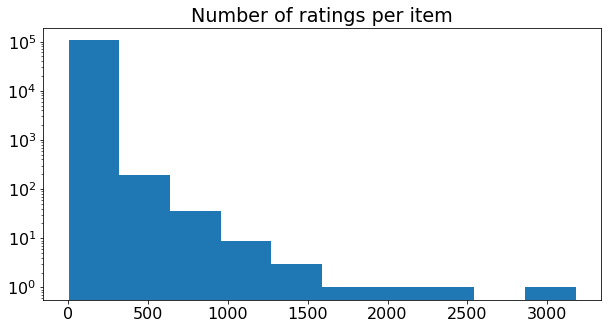

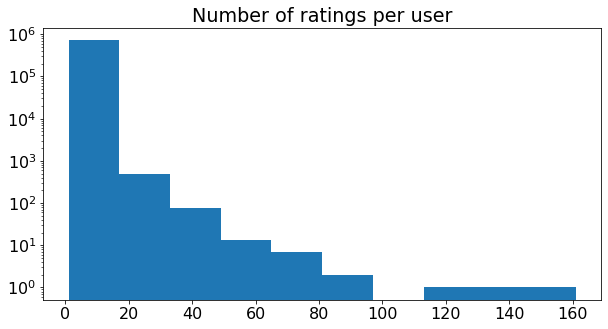

In [18]:
def make_num_ratings_hist(X, title=None):
    plt.figure(figsize=(10,5))
    plt.yscale('log', nonposy='clip')
    plt.hist(np.sum(X>0, axis=1))
    plt.title(title)
    plt.show()
    
make_num_ratings_hist(X_user_item.T, "Number of ratings per item")
make_num_ratings_hist(X_user_item, "Number of ratings per user")

- Note the log scales on the vertical axes. 
- We can see some "super items" and "super reviewers".

In [20]:
np.min(np.sum(X_user_item>0, axis=1))

1

In [21]:
np.min(np.sum(X_user_item>0, axis=0))

1

#### Our goal

- Our goal for today is to recommend similar items given a query item.
- This is like the "Customers also shopped for" section on Amazon.

## Vectors, distances, neighbours (20 min)

#### Distances between points

- First, we need to talk a bit about vectors and distances.
- Let's return to to the cities dataset from the beginning of the course.

In [22]:
cities_df = pd.read_csv('data/cities_USA.csv', index_col=0)

In [23]:
blue = cities_df.query('vote == "blue"')
red  = cities_df.query('vote == "red"')

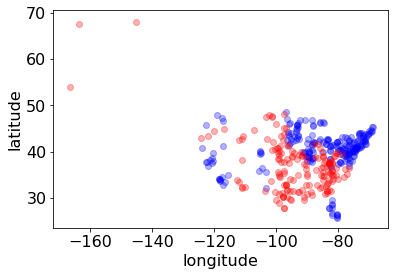

In [24]:
plt.scatter(blue["lon"], blue["lat"], color="blue", alpha=0.3);
plt.scatter(red["lon"], red["lat"], color="red", alpha=0.3);
plt.ylabel("latitude");
plt.xlabel("longitude");

Let's take 2 points:

In [25]:
two_cities = cities_df.sample(2, random_state=30).drop(columns=['vote'])

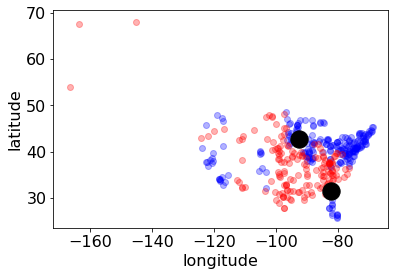

In [26]:
plt.scatter(blue["lon"], blue["lat"], color="blue", alpha=0.3);
plt.scatter(red["lon"], red["lat"], color="red", alpha=0.3);
plt.scatter(two_cities["lon"], two_cities["lat"], color="black", s=300);
plt.ylabel("latitude");
plt.xlabel("longitude");

- For the cities at the two big cicles, what is the _distance_ between them?

In [27]:
two_cities

,lon,lat
36,-82.249594,31.402780
317,-92.341701,42.673137


Subtract the two cities:

In [28]:
two_cities.iloc[1] - two_cities.iloc[0]

lon   -10.092107
lat    11.270357
dtype: float64

Square the differences:

In [29]:
(two_cities.iloc[1] - two_cities.iloc[0])**2

lon    101.850624
lat    127.020947
dtype: float64

Sum them up:

In [30]:
np.sum((two_cities.iloc[1] - two_cities.iloc[0])**2)

228.8715706068982

Take the square root:

In [31]:
np.sqrt(np.sum((two_cities.iloc[1] - two_cities.iloc[0])**2))

15.128501928707223

The above is called the Euclidean distance. 

In [32]:
sklearn.metrics.pairwise.euclidean_distances(two_cities)

array([[ 0.        , 15.12850193],
       [15.12850193,  0.        ]])

#### Finding the nearest neighbour

We can find the closest cities to City 0:

In [33]:
dists = sklearn.metrics.pairwise.euclidean_distances(cities_df[["lat", "lon"]])
dists

array([[ 0.        ,  0.25726537,  0.54650006, ..., 90.84357803,
        93.51968715, 77.8168621 ],
       [ 0.25726537,  0.        ,  0.31414736, ..., 90.71632405,
        93.36044603, 77.63631694],
       [ 0.54650006,  0.31414736,  0.        , ..., 90.74184686,
        93.33882475, 77.58040549],
       ...,
       [90.84357803, 90.71632405, 90.74184686, ...,  0.        ,
        14.0576291 , 25.4251158 ],
       [93.51968715, 93.36044603, 93.33882475, ..., 14.0576291 ,
         0.        , 18.31512614],
       [77.8168621 , 77.63631694, 77.58040549, ..., 25.4251158 ,
        18.31512614,  0.        ]])

In [34]:
dists.shape

(400, 400)

In [35]:
cities_df.shape

(400, 3)

These are the distances between City 0 and all other cities:

In [36]:
dists[0][:10]

array([ 0.        ,  0.25726537,  0.54650006,  0.60587695,  1.75469731,
        0.76859092,  1.97778941,  2.61609123,  3.28633296, 17.38999653])

We can find the smallest with `np.argmin`:

In [37]:
np.argmin(dists[0])

0

Whoops, that just says city 0 is closest to city 0...

In [38]:
np.fill_diagonal(dists, np.inf)
dists

array([[        inf,  0.25726537,  0.54650006, ..., 90.84357803,
        93.51968715, 77.8168621 ],
       [ 0.25726537,         inf,  0.31414736, ..., 90.71632405,
        93.36044603, 77.63631694],
       [ 0.54650006,  0.31414736,         inf, ..., 90.74184686,
        93.33882475, 77.58040549],
       ...,
       [90.84357803, 90.71632405, 90.74184686, ...,         inf,
        14.0576291 , 25.4251158 ],
       [93.51968715, 93.36044603, 93.33882475, ..., 14.0576291 ,
                inf, 18.31512614],
       [77.8168621 , 77.63631694, 77.58040549, ..., 25.4251158 ,
        18.31512614,         inf]])

In [39]:
np.argmin(dists[0])

1

Ok, so the closest city to City 0 is City 1. 

#### Finding the distances to a query point

We can also find the distances to a new "test" or "query" city:

In [40]:
dists = sklearn.metrics.pairwise.euclidean_distances(cities_df[["lat", "lon"]], [[0, 0]])
dists[:10]

array([[ 84.17901524],
       [ 84.30562848],
       [ 84.28113295],
       [ 84.4453635 ],
       [ 85.92913939],
       [ 84.32289429],
       [ 86.10623378],
       [ 86.36094249],
       [ 87.25286283],
       [101.30925538]])

In [41]:
np.argmin(dists)

357

Apparently City 357 is closest to the point $(0,0)$.

#### Using sklearn `NearestNeighbours`

In [42]:
from sklearn.neighbors import NearestNeighbors

In [43]:
nn = NearestNeighbors(n_neighbors=1)
nn.fit(cities_df[['lon', 'lat']]);

In [44]:
nn.kneighbors([[0,0]])

(array([[81.81189213]]), array([[357]]))

There is is again: City 357, with a distance of around 82.

#### Beyond 2 dimensions

- All this matches our intuition of "distance" in the real world.
- And we could also extend it to points in 3D space.
- In fact, we can extend it to arrays ("vectors") of any length:

In [1]:
from load_process_data import load_housing

In [2]:
X_train_enc, X_valid_enc, X_test_enc, _, _, _ = load_housing()

In [3]:
X_train_enc.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,Fence_?,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw
1341,-0.165978,0.338699,-0.062802,-0.505587,1.048406,0.927764,-0.577947,0.791412,-0.284437,-0.622612,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
459,-0.026237,-0.354633,-0.764983,-1.415471,-0.731683,-1.679272,0.294327,-0.544487,-0.284437,-0.120404,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
367,1.464330,-0.133037,-0.062802,-0.505587,-0.328644,-1.099931,1.074497,-0.149451,-0.284437,0.336963,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
894,-0.259139,-0.354322,-0.764983,-0.505587,0.242328,-0.279197,-0.577947,-0.937398,-0.284437,-1.295212,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
672,-0.026237,0.084927,-0.062802,0.404297,0.175155,-0.375754,-0.577947,0.691592,-0.284437,-0.306490,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


- Each house is now a length-288 vectors (288 columns).
- We could compute the distance between them.

In [ ]:
dists = sklearn.metrics.pairwise.euclidean_distances(X_train_enc[:3])
dists

That is, the distance between house 1 and house 2 is:

In [58]:
dists[1,2]

9.060830830748632

Find the most similar training house to test house 1:

In [59]:
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_train_enc);

In [60]:
nn.kneighbors(X_test_enc.iloc[[1]])

(array([[6.51274375]]), array([[388]]))

You can also ask `NearestNeighbors` to return, say, the 5 nearest neighbours:

Find the 5 most similar training houses to test house 1:

In [61]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_train_enc);

In [62]:
nn.kneighbors(X_test_enc.iloc[1])

ValueError: Expected 2D array, got 1D array instead:
array=[-0.44545957 -0.08632999 -1.46716466 -3.23523957 -2.41101151 -1.67927224
 -0.57794654 -0.93739797 -0.28443708  1.15977658  0.06024341 -0.19397144
  0.79391412 -0.1032243   0.48465406  1.14239193 -0.24387662  0.76617622
 -0.75040949  0.91073344 -0.96016199 -2.4904419   1.64595881  1.41596003
 -0.75864513 -0.70400824  1.17250623 -0.11753867 -0.26509024 -0.08103614
 -0.09284064 -1.36920884  2.          2.          2.          1.
  1.          2.          3.          1.          1.          3.
  0.          0.          0.          1.          1.          0.
  0.          1.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          1.          0.
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          1.          0.          0.
  1.          0.          0.          0.          0.          0.
  1.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

- You'll see this error a lot. 
- We need to pass in something 2D:

In [63]:
X_test_enc.iloc[1].shape

(288,)

In [64]:
X_test_enc.iloc[[1]].shape

(1, 288)

In [65]:
nn.kneighbors(X_test_enc.iloc[[1]])

(array([[6.51274375, 6.94582879, 7.26153825, 7.83754061, 7.86327248]]),
 array([[388, 754, 989, 532, 811]]))

## KNN for product similarity (5 min)

Let's find find the 5 items most similar to [GRILL HOGS 18" GRILL CLEANING BRUSH](https://www.amazon.com/dp/B00CFM0P7Y). 

In [66]:
grill_brush = "B00CFM0P7Y"
grill_brush_ind = item_mapper[grill_brush]
grill_brush_vec = X_user_item[grill_brush_ind]

Here is the strategy:

- We have a matrix `X_user_item` of users x items.
- Let's transpose it:

In [67]:
X_item_user = X_user_item.T

In [68]:
X_user_item.shape

(714791, 105984)

In [69]:
X_item_user.shape

(105984, 714791)

In [ ]:
# type(X_item_user)

In [ ]:
# type(X_user_item)

- This is now items x users.
- Each item is an observation, and we treat the users as features/columns.
- Assumption: **a similar item is an item that receives similar reviews by the same people.**
- In that case, we can just use nearest neighbours!

In [70]:
nn = NearestNeighbors(n_neighbors=6)
nn.fit(X_item_user);

In [71]:
distances, nearby_items = nn.kneighbors(X_item_user[grill_brush_ind])
nearby_items

array([[ 93652, 103866, 103865,  98897,  72226, 102810]])

The first one is the grill brush itself:

In [72]:
grill_brush_ind

93652

So the neighbours are:

In [73]:
nearby_items = np.squeeze(nearby_items)[1:]
nearby_items

array([103866, 103865,  98897,  72226, 102810])

In [74]:
for item in nearby_items:
    disp_url(item_inverse_mapper[item])

In [87]:
distances

array([[ 0.        , 74.24284477, 75.14652354, 76.51797175, 76.51797175,
        76.51797175]])

How many reviews does the grill brush have?

In [90]:
(X_item_user[grill_brush_ind] > 0).sum()

272

How many reviewers do they have in common?

In [92]:
for item in nearby_items:
    print(np.sum(np.squeeze(X_item_user[grill_brush_ind].toarray()) * np.squeeze(X_item_user[item].toarray()) >0))

37
28
1
1
1


## Break (5 min)

## Aside: Intuition in high dimensions

- In the cities case, we had 2 dimensions.
- In the Amazon case, we have

In [93]:
n_users

714791

- A lot of our intuition is not usable in high dimensions.
- Example: you have a circle of radius 1. What fraction of the area is within radius 0.999?

In [94]:
r = 0.999
np.pi*r*r/(np.pi*1*1)

0.9980010000000001

Most of the area, as expected!

- Actually we don't care about the factors, which cancel out.
- And the denominator is 1.
- So the ratio is just $r^2$

In [95]:
r**2

0.998001

You have a sphere of radius 1. What fraction of the volume is within radius 0.999?

In [96]:
r**3

0.997002999

- Still most. 
- OK, what about 700,000 dimensions? Any guesses?

In [97]:
r**n_users

2.5995282301993e-311

- Basically nothing. What about radius 0.999999?

In [98]:
0.999999 ** n_users

0.4892941887508955

All that is to say, don't trust your intuition when there's a huge number of dimensions!

## Cosine similarity (15 min)



- Is Euclidean distance the best choice?
- Are similar items near each other?
- Let's say there are 2 users, Alice and Bob.

In [99]:
df = pd.DataFrame(data=[[5, 0], [1, 2], [5, 5]], columns=["Alice", "Bob"], index=["Query", "Item 1", "Item 2"])
df

,Alice,Bob
Query,5,0
Item 1,1,2
Item 2,5,5


Which item do you consider more similar to the Query item, Item 1 or Item 2?

<br><br><br><br><br><br>

- I would say Item 2, because Alice liked both Item 2 and Query.
- Let's look at them as vectors:

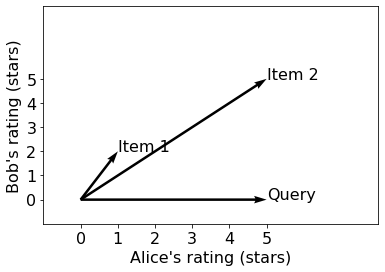

In [102]:
plt.quiver(0, 0, df["Alice"], df["Bob"], angles='xy', scale_units='xy', scale=1);
plt.xlim([-1, 8]);
plt.ylim([-1, 8]);
plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5])
for ind, val in df.iterrows():
    plt.text(val["Alice"], val["Bob"], ind);
plt.xlabel("Alice's rating (stars)");
plt.ylabel("Bob's rating (stars)");
# plt.axis('equal');

Question: which has a smaller distance to the Query item, Item 1 or Item 2?

In [103]:
dists_df = pd.DataFrame(data=sklearn.metrics.pairwise.euclidean_distances(df), columns=df.index, index=df.index)
dists_df

,Query,Item 1,Item 2
Query,0.000000,4.472136,5.0
Item 1,4.472136,0.000000,5.0
Item 2,5.000000,5.000000,0.0


- Item 1, apparently.
- However, if we look at the **angle** instead of the distance, then we get Item 2:

![](img/cosine_sim.png)

- Enter **cosine similarity**, which looks at the angle instead of the distance.
- But furthermore, what is really the goal here, just similarity?
- Wouldn't it make sense to typically recommend items that are more popular in general?
- Even if we weren't sure whether Item 1 or Item 2 was more similar, Item 2 is more popular, so let's recommend that?
- It turns out cosine similarity helps with that as well.
  - Why? It has to do with high-dimensional intuition again.
  - Combined with the fact that these vectors are actually quite sparse.
  - We won't go into detail here.

Let's use cosine similarity instead of Euclidean distance in `NearestNeighbors`, and find the 5 products most similar to `B00CFM0P7Y`.

In [104]:
nn_cos = NearestNeighbors(n_neighbors=6, metric='cosine')
nn_cos.fit(X_item_user);

In [105]:
distances_cos, nearby_items_cos = nn_cos.kneighbors(X_item_user[grill_brush_ind])
nearby_items_cos

array([[ 93652, 103866, 103867, 103865,  98068,  98066]])

In [106]:
nearby_items_cos = np.squeeze(nearby_items_cos)[1:]
nearby_items_cos

array([103866, 103867, 103865,  98068,  98066])

Let's compare the results of Euclidean vs. cosine distance:

In [107]:
def print_item_pop(items_idx):
    popularity = np.sum(X_item_user[items_idx], axis=1)
    for item in items_idx:
        disp_url(item_inverse_mapper[item])
    for i in range(len(items_idx)):
        print(f"Total stars: {int(popularity[i,0])}")

In [108]:
print("Euclidean items/popularity:")
print_item_pop(nearby_items)

Euclidean items/popularity:


Total stars: 266
Total stars: 205
Total stars: 5
Total stars: 5
Total stars: 5


In [109]:
print("Cosine items/popularity:")
print_item_pop(nearby_items_cos)

Cosine items/popularity:


Total stars: 266
Total stars: 438
Total stars: 205
Total stars: 311
Total stars: 513


The results make sense, as we can expect more popular items given by the cosine metric than the Euclidean distance. 

#### (optional) Scaling

BTW, should we scale our features?

In [110]:
np.mean(X_item_user, axis=0)

matrix([[1.88707729e-05, 4.71769324e-05, 8.49184783e-05, ...,
         4.71769324e-05, 3.77415459e-05, 9.43538647e-05]])

- Should we subtract these means?

<br><br><br><br><br><br>

- Problem: if we do, it would no longer be mostly zeros!
- If we had to store this as a dense matrix, it would be way too large.
- Can we still scale if we can't shift? Sure, although there are some computational issues with sparse matrices.
- It turns out scaled Euclidean and cosine similarity yield the name KNNs.

#### Not covered / extensions

- Can I recommend a project _for a specific user_?
- One approach: Can we predict the missing ratings? (And then take high predicted rating.)
- That was the Netflix Prize I mentioned earlier.
- This is covered in CPSC 340 using a method called collaborative filtering.

## KNN for supervised learning (10 min)

#### Classification

- Here is some toy data for binary classification.
- I want to predict the point in grey.

![](img/scatter.png)

- An intuitive way to do this is predict the grey point using the same label as the next "closest" point ($k = 1$)
- We would predict a target of **1 (orange)** in this case

![](img/scatter_k1.png)


- We could also use the 3 closest points ($k = 3$)...
- We would predict a target of **0 (blue)** in this case

![](img/scatter_k3.png)

Going back to the cities dataset:

In [111]:
cities_df_train, cities_df_test = train_test_split(cities_df)

In [112]:
X_train = cities_df_train.drop(columns=['vote'])
X_test = cities_df_test.drop(columns=['vote'])
y_train = cities_df_train['vote']
y_test = cities_df_test['vote']

In [113]:
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train);

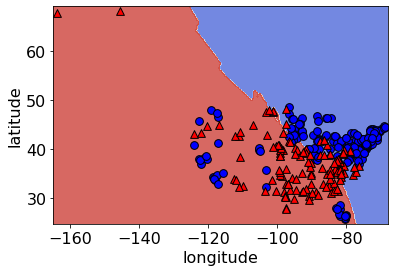

In [114]:
plot_classifier(X_train, y_train, knn, ax=plt.gca(), ticks=True);
plt.ylabel("latitude");
plt.xlabel("longitude");

In [115]:
knn.score(X_train, y_train)

0.74

In [116]:
knn.score(X_test, y_test)

0.79

- $k$ is a hyperparameter
- What happens when we play around with $k$?
  - smaller $k$: lower training error, higher approximation error.

In [117]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train);

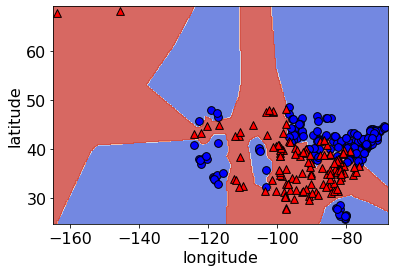

In [118]:
plot_classifier(X_train, y_train, knn, ax=plt.gca(), ticks=True);
plt.ylabel("latitude");
plt.xlabel("longitude");

In [119]:
knn.score(X_train, y_train)

1.0

In [120]:
knn.score(X_test, y_test)

0.98

- Like the RBF SVM, with KNN we can get arbitrarily high training accuracy.
- In fact the two are quite similar to each other in general.

## Regression

- In KNN regression we take the average of the $k$ nearest neighbours
- Note: regression plots more natural in 1D, classification in 2D, but of course we can do either for any $d$

In [139]:
n = 30 # number of samples
np.random.seed(0) # fix seed for reproducibility
X = np.linspace(-1,1,n)+np.random.randn(n)*0.01
X = X[:, None]
y = np.random.randn(n,1) + X*5

With $k=1$:

In [140]:
knn = KNeighborsRegressor(n_neighbors=1, weights='uniform').fit(X, y)

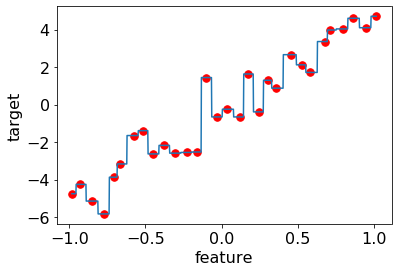

In [141]:
plt.plot(X, y, '.r', markersize=15)
grid = np.linspace(np.min(X), np.max(X), 1000)[:,None]
plt.plot(grid, knn.predict(grid));
plt.xlabel('feature');
plt.ylabel('target');

In [142]:
knn.score(X, y)

1.0

And with $k=10$:

In [147]:
knn = KNeighborsRegressor(n_neighbors=10, weights='uniform').fit(X, y)

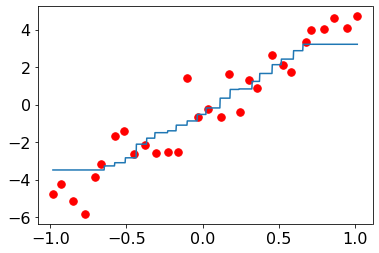

In [148]:
plt.plot(X, y, '.r', markersize=15)
plt.plot(grid, knn.predict(grid));

In [149]:
knn.score(X, y)

0.8671815772959105

In [150]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance').fit(X, y)

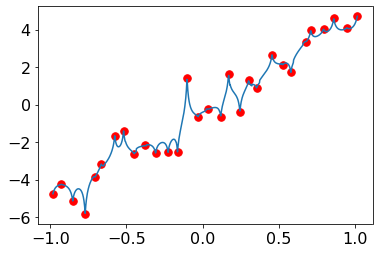

In [151]:
plt.plot(X, y, '.r', markersize=15)
plt.plot(grid, knn.predict(grid));

- So, we have KNN as a new supervised learning technique in our toolbox.
- It can be used for classification or regression (much like the other methods we've seen).
- It works by finding the $k$ closest neighbours to a given "query point".
- This fundamentally relies on a choice if distance.
- sklearn's KNN methods use Euclidean distance by default, but you can set others.

#### Pros/cons of KNN for supervised learning

Pros:

- Easy to understand, interpret.
- Simply hyperparameter controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.

Cons:

- Can be potentially be VERY slow.
- Often not that great test accuracy.

Note: for regular KNN for supervised learning (not with sparse matrices), you should scale your features.

## True/False questions (10 min)

1. Our method would never recommend an item if it had no common reviewers with the query item. 
2. If we transposed our item-user matrix into a user-item matrix, we could use all the same methods to find similar users to a query user.
3. KNN classification with $k=1$ is guaranteed to get 0 training error.
4. Unlike linear regression, KNN regression needs to consult the training data when calling `predict`.